<a href="https://colab.research.google.com/github/Harish34272/Predictive-modellling-for-glaucoma-prediction-/blob/main/vgg16_early_glaucoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential, Model , load_model
from keras.preprocessing.image import ImageDataGenerator , load_img, img_to_array
from keras.optimizers import Adam
from keras.applications import VGG16,ResNet50
from keras.layers import Dense ,Flatten , Conv2D, MaxPooling2D, UpSampling2D, MaxPool2D, BatchNormalization, Activation , Add , Input
from keras.layers import GlobalAveragePooling2D
from scipy.signal.windows import gaussian
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc,classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ModelCheckpoint,EarlyStopping
from imblearn.over_sampling import RandomOverSampler
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))

In [ ]:
img_height = 224
img_width = 224
batch_size = 32
base_dirs = {
    'train': r'/content/drive/MyDrive/datasets/real_combined_last_dataset/train',
    'test': r'/content/drive/MyDrive/datasets/real_combined_last_dataset/test',
    'val': r'/content/drive/MyDrive/datasets/real_combined_last_dataset/val'
}

In [ ]:
datagen_minority = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,  # Increase rotation range for more diversity
    width_shift_range=0.3,

    height_shift_range=0.3,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

def data_generator(directory):
    # Use 'datagen_minority' for minority classes and 'datagen' for others
    if 'normal' or 'early_glaucoma' in directory:
        return datagen_minority.flow_from_directory(
            directory,
            target_size=(img_height, img_width),
            batch_size=32,
            class_mode='categorical',
            shuffle=False,
            seed=42
        )
    else:
        return datagen.flow_from_directory(
            directory,
            target_size=(img_height, img_width),
            batch_size=32,
            class_mode='categorical',
            shuffle=False,
            seed=42
        )

train_ds = data_generator(base_dirs['train'])
test_ds = data_generator(base_dirs['test'])
val_ds = data_generator(base_dirs['val'])

# Assuming labels are directly associated with filenames in the training directory
class_indices = {'glaucoma': 1, 'normal': 0, 'early_glaucoma': 2}
train_ds.class_indices = class_indices
test_ds.class_indices = class_indices
val_ds.class_indices = class_indices

train_ds.classes = np.array([class_indices[label.split('/')[0]] for label in train_ds.filenames])

print("Length of training labels:", len(train_ds.classes))
print("Number of images in the training directory:", len(train_ds.filenames))
print(f"Class indices in ", test_ds.class_indices)

Found 6207 images belonging to 3 classes.
Found 819 images belonging to 3 classes.
Found 801 images belonging to 3 classes.
Length of training labels: 6207
Number of images in the training directory: 6207
Class indices in  {'glaucoma': 1, 'normal': 0, 'early_glaucoma': 2}


In [ ]:
datagen_glaucoma = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

def data_generator(directory):
    return datagen_glaucoma.flow_from_directory(
        directory,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        classes=['glaucoma'],
        class_mode='categorical',
        shuffle=True,  # Set to True if you want to shuffle the data
        seed=42
    )

train_ds = data_generator(base_dirs['train'])
test_ds = data_generator(base_dirs['test'])
val_ds = data_generator(base_dirs['val'])
class_indices = {'glaucoma': 1, 'normal': 0, 'early_glaucoma': 2}
train_ds.class_indices = class_indices
test_ds.class_indices = class_indices
val_ds.class_indices = class_indices
print(f"Class indices in ", train_ds.class_indices)

Found 4404 images belonging to 1 classes.
Found 571 images belonging to 1 classes.
Found 570 images belonging to 1 classes.
Class indices in  {'glaucoma': 1, 'normal': 0, 'early_glaucoma': 2}


In [ ]:
datagen_glaucoma = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

def data_generator(directory):
    return datagen_glaucoma.flow_from_directory(
        directory,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        classes=['early_glaucoma','normal'],
        class_mode='categorical',
        shuffle=True,  # Set to True if you want to shuffle the data
        seed=42
    )

train_ds = data_generator(base_dirs['train'])
test_ds = data_generator(base_dirs['test'])
val_ds = data_generator(base_dirs['val'])
class_indices = {'normal': 0, 'early_glaucoma': 2}
train_ds.class_indices = class_indices
test_ds.class_indices = class_indices
val_ds.class_indices = class_indices
print(f"Class indices in ", train_ds.class_indices)

Found 1803 images belonging to 2 classes.
Found 248 images belonging to 2 classes.
Found 231 images belonging to 2 classes.
Class indices in  {'normal': 0, 'early_glaucoma': 2}


datagen_normal = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

def data_generator(directory):
    return datagen_normal.flow_from_directory(
        directory,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        classes=['normal'],
        class_mode='categorical',
        shuffle=True,  # Set to True if you want to shuffle the data
        seed=42
    )

train_ds = data_generator(base_dirs['train'])
test_ds = data_generator(base_dirs['test'])
val_ds = data_generator(base_dirs['val'])

datagen_early = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

def data_generator(directory):
    return datagen_early.flow_from_directory(
        directory,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        classes=['early_glaucoma'],
        class_mode='categorical',
        shuffle=True,  # Set to True if you want to shuffle the data
        seed=42
    )

train_ds = data_generator(base_dirs['train'])
test_ds = data_generator(base_dirs['test'])
val_ds = data_generator(base_dirs['val'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [ ]:
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [ ]:
def vgg16_layers(base_model):
    model = Sequential()

    model.add(base_model)
    # Add a GlobalAveragePooling2D layer instead of the previous MaxPooling2D layer
    model.add(GlobalAveragePooling2D())

    # Add your custom fully connected layers
    model.add(Dense(units=4096, activation='relu'))
    model.add(Dense(units=4096, activation='relu'))
    model.add(Dense(units=3, activation='softmax'))

    # Add Optimizer and check accuracy metrics
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
def vgg16_model(model, train_ds, test_ds):
    class_labels = np.unique(train_ds.classes)
    class_indices = {label: index for index, label in enumerate(class_labels)}

    # Calculate class weights manually
    class_counts = np.bincount(train_ds.classes)
    total_samples = np.sum(class_counts)
    class_weights = {0: 4.0, 1: 1.0, 2: 5.0}
    history = model.fit(train_ds, epochs=10, callbacks=[early_stopping], validation_data=val_ds, class_weight=class_weights, verbose=1)


    #model.save('datasets/real_combined_last_dataset2/vgg16(copy 20 1).h5', save_format='h5')
    test_result = model.evaluate(test_ds)
    print(f"Test Loss: {test_result[0]}, Test Accuracy: {test_result[1]}")
    predictions = model.predict(test_ds)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_ds.classes

# Visualize the confusion matrix
    class_names = ['normal', 'glaucoma', 'early_glaucoma']  # Update with your class names
    plot_confusion_matrix(true_labels, predicted_labels, class_names)
    print("Class Labels:")
    for i, class_name in enumerate(class_names):
        print(f"{i}: {class_name}")
    report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print("Classification Report:\n", report)
    plots = plot_train_history(history)
    return model,history

In [ ]:
def fine_tune_model(model, train_ds, val_ds, epochs=10):
    # Freeze layers except for the last few
    for layer in model.layers[:-6]:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    # Continue training on your dataset
    history = model.fit(train_ds, epochs=epochs, callbacks=[early_stopping], validation_data=val_ds, verbose=1)

    return model, history

# Load the pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add your custom layers on top of the pre-trained model
g_model = vgg16_layers(base_model)

# Fine-tune the model
g_model, g_history = fine_tune_model(g_model, train_ds, val_ds, epochs=5)  # You can adjust the number of epochs

# Save the fine-tuned model
model_path = '/content/drive/MyDrive/datasets/real_combined_last_dataset/glaucoma.keras'
g_model.save(model_path)


Epoch 1/5
57/57 [==============================] - 3740s 65s/step - loss: 0.4197 - accuracy: 0.8286 - val_loss: 0.2886 - val_accuracy: 0.8268
Epoch 2/5
57/57 [==============================] - 3650s 64s/step - loss: 0.2606 - accuracy: 0.8697 - val_loss: 0.2842 - val_accuracy: 0.8225
Epoch 3/5
57/57 [==============================] - 3633s 64s/step - loss: 0.2361 - accuracy: 0.8697 - val_loss: 0.2209 - val_accuracy: 0.8658
Epoch 4/5
57/57 [==============================] - 3615s 63s/step - loss: 0.2058 - accuracy: 0.8808 - val_loss: 0.2772 - val_accuracy: 0.8528
Epoch 5/5
57/57 [==============================] - 3621s 63s/step - loss: 0.1888 - accuracy: 0.9007 - val_loss: 0.2669 - val_accuracy: 0.8615


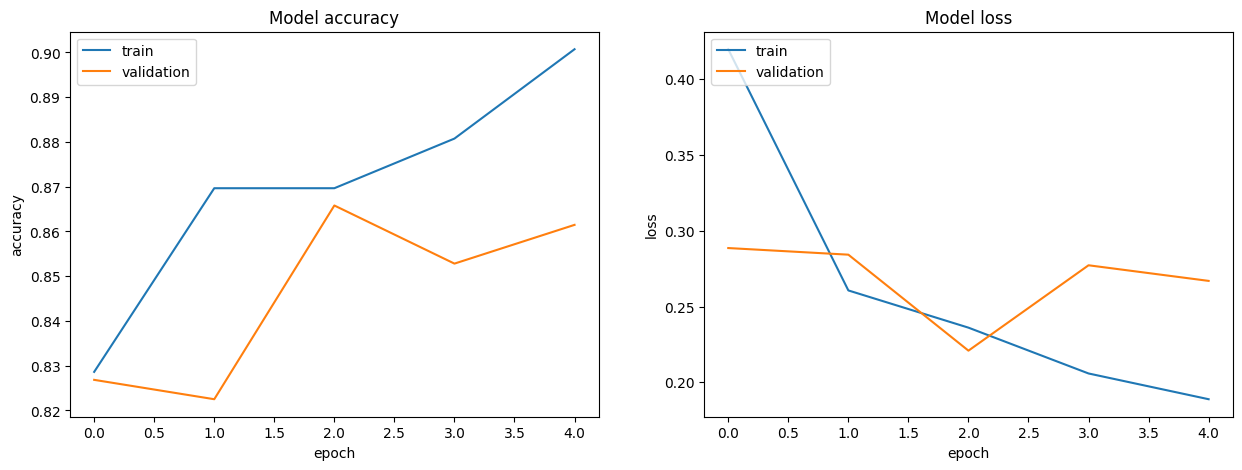

In [ ]:
plot_train_history(g_history)

8/8 [==============================] - 140s 17s/step - loss: 0.1899 - accuracy: 0.9153
Test Loss: 0.1898815929889679, Test Accuracy: 0.9153226017951965
8/8 [==============================] - 142s 17s/step


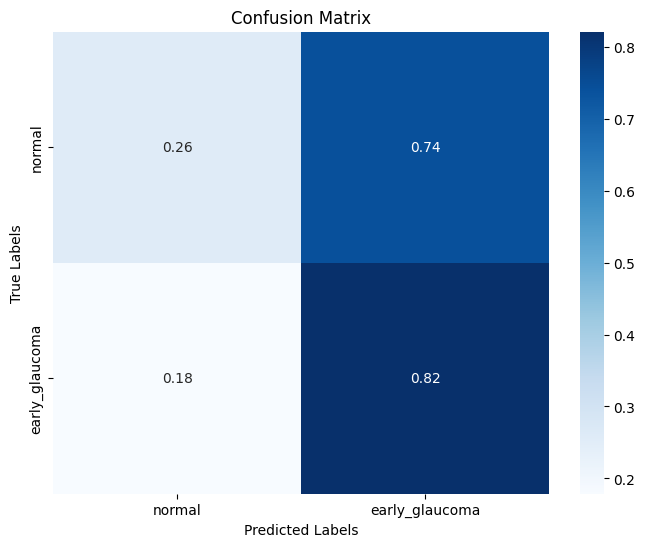

In [ ]:
test_result = g_model.evaluate(test_ds)
print(f"Test Loss: {test_result[0]}, Test Accuracy: {test_result[1]}")
predictions_g = g_model.predict(test_ds)
predicted_g_labels = np.argmax(predictions_g, axis=1)
true_labels = test_ds.classes

# Visualize the confusion matrix
class_names = ['normal', 'early_glaucoma']  # Update with your class names
plot_confusion_matrix(true_labels, predicted_g_labels, class_names)

In [ ]:
print("Class Labels:")
for i, class_name in enumerate(train_ds.class_indices):
      print(f"{i}: {class_name}")
report = classification_report(true_labels, predicted_g_labels, target_names=class_names)
print("Classification Report:\n", report)

Class Labels:
0: glaucoma
1: normal
2: early_glaucoma
Classification Report:
                 precision    recall  f1-score   support

        normal       0.31      0.26      0.28        58
early_glaucoma       0.78      0.82      0.80       190

      accuracy                           0.69       248
     macro avg       0.55      0.54      0.54       248
  weighted avg       0.67      0.69      0.68       248



In [ ]:
import cv2
import numpy as np

def preprocess_image(image_path):
    # Read the image
    img = cv2.imread(image_path)
    # Resize the image to match the model's expected sizing
    img = cv2.resize(img, (224, 224))
    # Expand the dimensions to match the model's expected input shape
    img = np.expand_dims(img, axis=0)
    # Normalize the pixel values to be between 0 and 1
    img = img / 255.0
    return img


In [ ]:
def predict_class(model, image_path):
    # Preprocess the image
    img = preprocess_image(image_path)
    # Make predictions
    predictions = model.predict(img)
    # Get the predicted class index
    predicted_class_index = np.argmax(predictions)
    return predicted_class_index


In [ ]:
def get_class_label(predicted_class_index):
    class_labels = ['normal', 'early_glaucoma']
    return class_labels[predicted_class_index]

In [ ]:
image_path = '/content/drive/MyDrive/datasets/real_combined_last_dataset/train/early_glaucoma/232.png'

predicted_index = predict_class(g_model, image_path)
predicted_label = get_class_label(predicted_index)
print(f"The predicted label for the image is: {predicted_label}")


1/1 [==============================] - 0s 491ms/step
The predicted label for the image is: early_glaucoma


In [ ]:
image_path = '/content/drive/MyDrive/datasets/real_combined_last_dataset/train/normal/1.png'

predicted_index = predict_class(g_model, image_path)
predicted_label = get_class_label(predicted_index)
print(f"The predicted label for the image is: {predicted_label}")


1/1 [==============================] - 1s 806ms/step
The predicted label for the image is: early_glaucoma


In [ ]:
print("Class Labels:")
for class_name, i in train_ds.class_indices.items():
    print(f"{i}: {class_name}")


Class Labels:
0: normal
2: early_glaucoma
